# Benchmark `distribute` CP vs HS

This notebook compares:

- `phantom/common/distribute/cp`
- `phantom/common/distribute/hs`

on random assignment problems with `N in {2, 4, 8, 16, 32, 64}` and square cost matrices (`n = m = N`).

In [1]:
from __future__ import annotations

import statistics
import time

import numpy as np

from phantom.common.distribute import _decode_assignment
from phantom.common.distribute.cp.solver import get_cp_solver
from phantom.common.distribute.hs.solver import get_hs_solver

SIZES = [2, 4, 8, 16, 32, 64]
PROBLEMS_PER_SIZE = 40
WARMUP_ROUNDS = 10
SEED = 7

In [2]:
def make_problems(size: int, count: int, rng: np.random.Generator) -> list[tuple[np.ndarray, np.ndarray]]:
    problems = []
    for _ in range(count):
        cost = rng.uniform(-2.0, 5.0, size=(size, size)).astype(float)
        max_assigned = np.ones(size, dtype=float)
        problems.append((cost, max_assigned))
    return problems


def assignment_objective(cost: np.ndarray, chosen: np.ndarray) -> float:
    rows = np.arange(chosen.shape[0])
    return float(cost[rows, chosen].sum())

In [3]:
rng = np.random.default_rng(SEED)
all_results = []

for size in SIZES:
    problems = make_problems(size=size, count=PROBLEMS_PER_SIZE, rng=rng)

    cp_solver = get_cp_solver(size, size)
    hs_solver = get_hs_solver(size, size)

    cp_times = []
    hs_times = []
    objective_deltas = []
    assignment_mismatches = 0

    for i in range(min(WARMUP_ROUNDS, len(problems))):
        cost, max_assigned = problems[i]
        cp_solver.set_total(np.zeros(size), 0)
        hs_solver.set_total(np.zeros(size), 0)
        _ = cp_solver.solve(cost, max_assigned)
        _ = hs_solver.solve(cost, max_assigned)

    for cost, max_assigned in problems:
        cp_solver.set_total(np.zeros(size), 0)
        t0 = time.perf_counter()
        cp_x = cp_solver.solve(cost, max_assigned)
        t1 = time.perf_counter()
        cp_times.append((t1 - t0) * 1000.0)

        hs_solver.set_total(np.zeros(size), 0)
        hs_start = time.perf_counter()
        hs_x = hs_solver.solve(cost, max_assigned)
        hs_end = time.perf_counter()
        hs_times.append((hs_end - hs_start) * 1000.0)

        cp_choice = _decode_assignment(cost, cp_x, max_assigned)
        hs_choice = _decode_assignment(cost, hs_x, max_assigned)

        if not np.array_equal(cp_choice, hs_choice):
            assignment_mismatches += 1

        cp_obj = assignment_objective(cost, cp_choice)
        hs_obj = assignment_objective(cost, hs_choice)
        objective_deltas.append(cp_obj - hs_obj)

    cp_ms_mean = statistics.mean(cp_times)
    hs_ms_mean = statistics.mean(hs_times)

    all_results.append(
        {
            "size": size,
            "cp_ms_mean": cp_ms_mean,
            "cp_ms_p95": float(np.percentile(cp_times, 95)),
            "hs_ms_mean": hs_ms_mean,
            "hs_ms_p95": float(np.percentile(hs_times, 95)),
            "speedup_hs_over_cp": cp_ms_mean / hs_ms_mean,
            "avg_obj_delta_cp_minus_hs": statistics.mean(objective_deltas),
            "assignment_mismatches": assignment_mismatches,
        }
    )

all_results

2026-02-21 04:08:55.939 | INFO     | phantom.common.distribute.cp.solver:__init__:10 - Compiling cvxpy problem with n=2, m=2, include_total=True
2026-02-21 04:08:55.941 | INFO     | phantom.common.distribute.hs.solver:__init__:12 - Compiling highspy problem with n=2, m=2, include_total=True
2026-02-21 04:08:56.017 | INFO     | phantom.common.distribute.cp.solver:__init__:10 - Compiling cvxpy problem with n=4, m=4, include_total=True
2026-02-21 04:08:56.019 | INFO     | phantom.common.distribute.hs.solver:__init__:12 - Compiling highspy problem with n=4, m=4, include_total=True
2026-02-21 04:08:56.089 | INFO     | phantom.common.distribute.cp.solver:__init__:10 - Compiling cvxpy problem with n=8, m=8, include_total=True
2026-02-21 04:08:56.091 | INFO     | phantom.common.distribute.hs.solver:__init__:12 - Compiling highspy problem with n=8, m=8, include_total=True
2026-02-21 04:08:56.176 | INFO     | phantom.common.distribute.cp.solver:__init__:10 - Compiling cvxpy problem with n=16, m=

[{'size': 2,
  'cp_ms_mean': 0.8840174974466208,
  'cp_ms_p95': 1.5576499878079626,
  'hs_ms_mean': 0.16960750035650562,
  'hs_ms_p95': 0.2074650044960432,
  'speedup_hs_over_cp': 5.212136819353299,
  'avg_obj_delta_cp_minus_hs': 0.0,
  'assignment_mismatches': 0},
 {'size': 4,
  'cp_ms_mean': 0.9133200015639886,
  'cp_ms_p95': 1.0510950000025332,
  'hs_ms_mean': 0.19211250073567498,
  'hs_ms_p95': 0.24366500292671842,
  'speedup_hs_over_cp': 4.754089390677462,
  'avg_obj_delta_cp_minus_hs': 0.0,
  'assignment_mismatches': 0},
 {'size': 8,
  'cp_ms_mean': 1.1099000006652204,
  'cp_ms_p95': 1.4378099971509068,
  'hs_ms_mean': 0.22441750079451595,
  'hs_ms_p95': 0.2852500016160775,
  'speedup_hs_over_cp': 4.945692723320546,
  'avg_obj_delta_cp_minus_hs': 0.0,
  'assignment_mismatches': 0},
 {'size': 16,
  'cp_ms_mean': 1.9314700006361818,
  'cp_ms_p95': 2.1816499989654403,
  'hs_ms_mean': 0.39400249734171666,
  'hs_ms_p95': 0.5214100041484925,
  'speedup_hs_over_cp': 4.902177051332307,
 

,size,cp_ms_mean,cp_ms_p95,hs_ms_mean,hs_ms_p95,speedup_hs_over_cp,avg_obj_delta_cp_minus_hs,assignment_mismatches
0,2,0.8840,1.5576,0.1696,0.2075,5.2121,0.0,0
1,4,0.9133,1.0511,0.1921,0.2437,4.7541,0.0,0
2,8,1.1099,1.4378,0.2244,0.2853,4.9457,0.0,0
3,16,1.9315,2.1816,0.3940,0.5214,4.9022,0.0,0
4,32,5.7745,6.5618,1.0300,1.3151,5.6061,0.0,0
5,64,23.6694,26.3655,3.2279,4.0129,7.3328,0.0,0


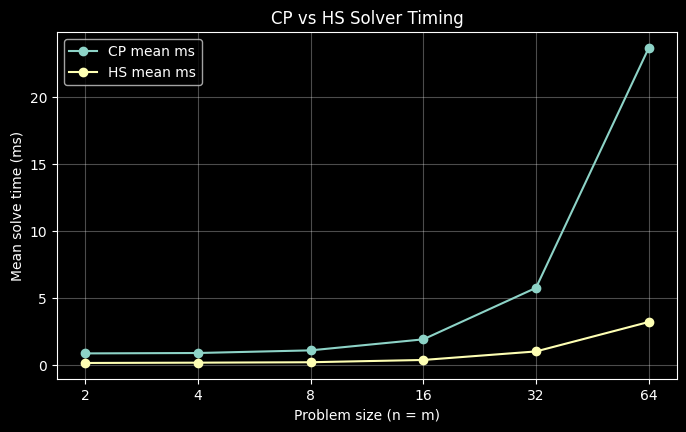

In [4]:
try:
    import pandas as pd

    df = pd.DataFrame(all_results)
    display(df.round(4))
except Exception:
    for row in all_results:
        print(row)

try:
    import matplotlib.pyplot as plt

    sizes = [row["size"] for row in all_results]
    cp_means = [row["cp_ms_mean"] for row in all_results]
    hs_means = [row["hs_ms_mean"] for row in all_results]

    plt.figure(figsize=(8, 4.5))
    plt.plot(sizes, cp_means, marker="o", label="CP mean ms")
    plt.plot(sizes, hs_means, marker="o", label="HS mean ms")
    plt.xscale("log", base=2)
    plt.xticks(sizes, sizes)
    plt.xlabel("Problem size (n = m)")
    plt.ylabel("Mean solve time (ms)")
    plt.title("CP vs HS Solver Timing")
    plt.grid(alpha=0.3)
    plt.legend()
    plt.show()
except Exception as ex:
    print(f"Skipping plot: {ex}")